In [1]:
# libraries for system
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# Para procesamiento de las imagenes
from PIL import Image
import os
import random
import shutil
import scipy.io.wavfile as wav

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.__version__)
if physical_devices:
    try:
        tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
        print("GPU is set for TensorFlow.")
    except RuntimeError as e:
        print("Error setting GPU: ", e)
else:
    print("No GPU found. TensorFlow will use the CPU")

2.10.1
GPU is set for TensorFlow.


In [2]:
def preprocess_and_save_image(src, dst, size=(100, 100)):
    img = Image.open(src)
    img = img.resize(size)
    # Convertir la imagen a modo RGB
    img = img.convert('RGB')
    img.save(dst)


def split_dataset(input_folder, output_folder, train_ratio=0.6, test_ratio=0.2, val_ratio=0.2, seed=None):

    if seed is not None:
        random.seed(seed)

    # Crear carpetas de salida
    train_dir = os.path.join(output_folder, 'train')
    test_dir = os.path.join(output_folder, 'test')
    val_dir = os.path.join(output_folder, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Iterar sobre subcarpetas
    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            class_files = os.listdir(class_path)
            random.shuffle(class_files)

            # Calcular el número de ejemplos para cada división.
            num_samples = len(class_files)
            num_train = int(train_ratio * num_samples)
            num_test = int(test_ratio * num_samples)
            num_val = num_samples - num_train - num_test

            # Asignar archivos a cada división
            train_files = class_files[:num_train]
            test_files = class_files[num_train:num_train + num_test]
            val_files = class_files[-num_val:]

            for files, folder in zip([train_files, test_files, val_files], [train_dir, test_dir, val_dir]):
                for filename in files:
                    src = os.path.join(class_path, filename)
                    dst = os.path.join(folder, class_folder, filename)
                    os.makedirs(os.path.dirname(dst), exist_ok=True)
                    preprocess_and_save_image(src, dst)


# Ejemplo:
input_folder = "./data/emociones"  # Ruta a la carpeta que contiene subcarpetas para cada clase
output_folder = "./emociones_procesadas"  # Ruta a la carpeta de salida donde se guardarán los conjuntos de train test  val
split_dataset(input_folder, output_folder)


In [2]:
train_dir = './emociones_procesadas/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,./emociones_procesadas/train\Angry\AndrikAngry...,Angry
1,./emociones_procesadas/train\Angry\AndrikAngry...,Angry
2,./emociones_procesadas/train\Angry\AndrikAngry...,Angry
3,./emociones_procesadas/train\Angry\AndrikAngry...,Angry
4,./emociones_procesadas/train\Angry\AndrikAngry...,Angry
...,...,...
171,./emociones_procesadas/train\Surprise\LuzSurpr...,Surprise
172,./emociones_procesadas/train\Surprise\LuzSurpr...,Surprise
173,./emociones_procesadas/train\Surprise\LuzSurpr...,Surprise
174,./emociones_procesadas/train\Surprise\LuzSurpr...,Surprise


In [3]:
# Generate  test data paths with labels
test_dir = './emociones_procesadas/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
test_df

,filepaths,labels
0,./emociones_procesadas/test\Angry\AndrikAngry1...,Angry
1,./emociones_procesadas/test\Angry\AndrikAngry5...,Angry
2,./emociones_procesadas/test\Angry\AndrikAngry6...,Angry
3,./emociones_procesadas/test\Angry\AndrikAngry9...,Angry
4,./emociones_procesadas/test\Angry\JulioAngry3....,Angry
...,...,...
68,./emociones_procesadas/test\Surprise\JulioSurp...,Surprise
69,./emociones_procesadas/test\Surprise\JulioSurp...,Surprise
70,./emociones_procesadas/test\Surprise\LuzSurpri...,Surprise
71,./emociones_procesadas/test\Surprise\LuzSurpri...,Surprise


In [4]:
# Generate  test data paths with labels
test_dir = './emociones_procesadas/val'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)
valid_df

,filepaths,labels
0,./emociones_procesadas/val\Angry\AndrikAngry5....,Angry
1,./emociones_procesadas/val\Angry\AndrikAngry8....,Angry
2,./emociones_procesadas/val\Angry\JulioAngry10....,Angry
3,./emociones_procesadas/val\Angry\JulioAngry2.jpeg,Angry
4,./emociones_procesadas/val\Angry\JulioAngry3.jpeg,Angry
...,...,...
72,./emociones_procesadas/val\Surprise\JulioSurpr...,Surprise
73,./emociones_procesadas/val\Surprise\JulioSurpr...,Surprise
74,./emociones_procesadas/val\Surprise\LuzSurpris...,Surprise
75,./emociones_procesadas/val\Surprise\LuzSurpris...,Surprise


In [5]:
# crobed image size
batch_size = 16
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 176 validated image filenames belonging to 7 classes.
Found 77 validated image filenames belonging to 7 classes.
Found 73 validated image filenames belonging to 7 classes.


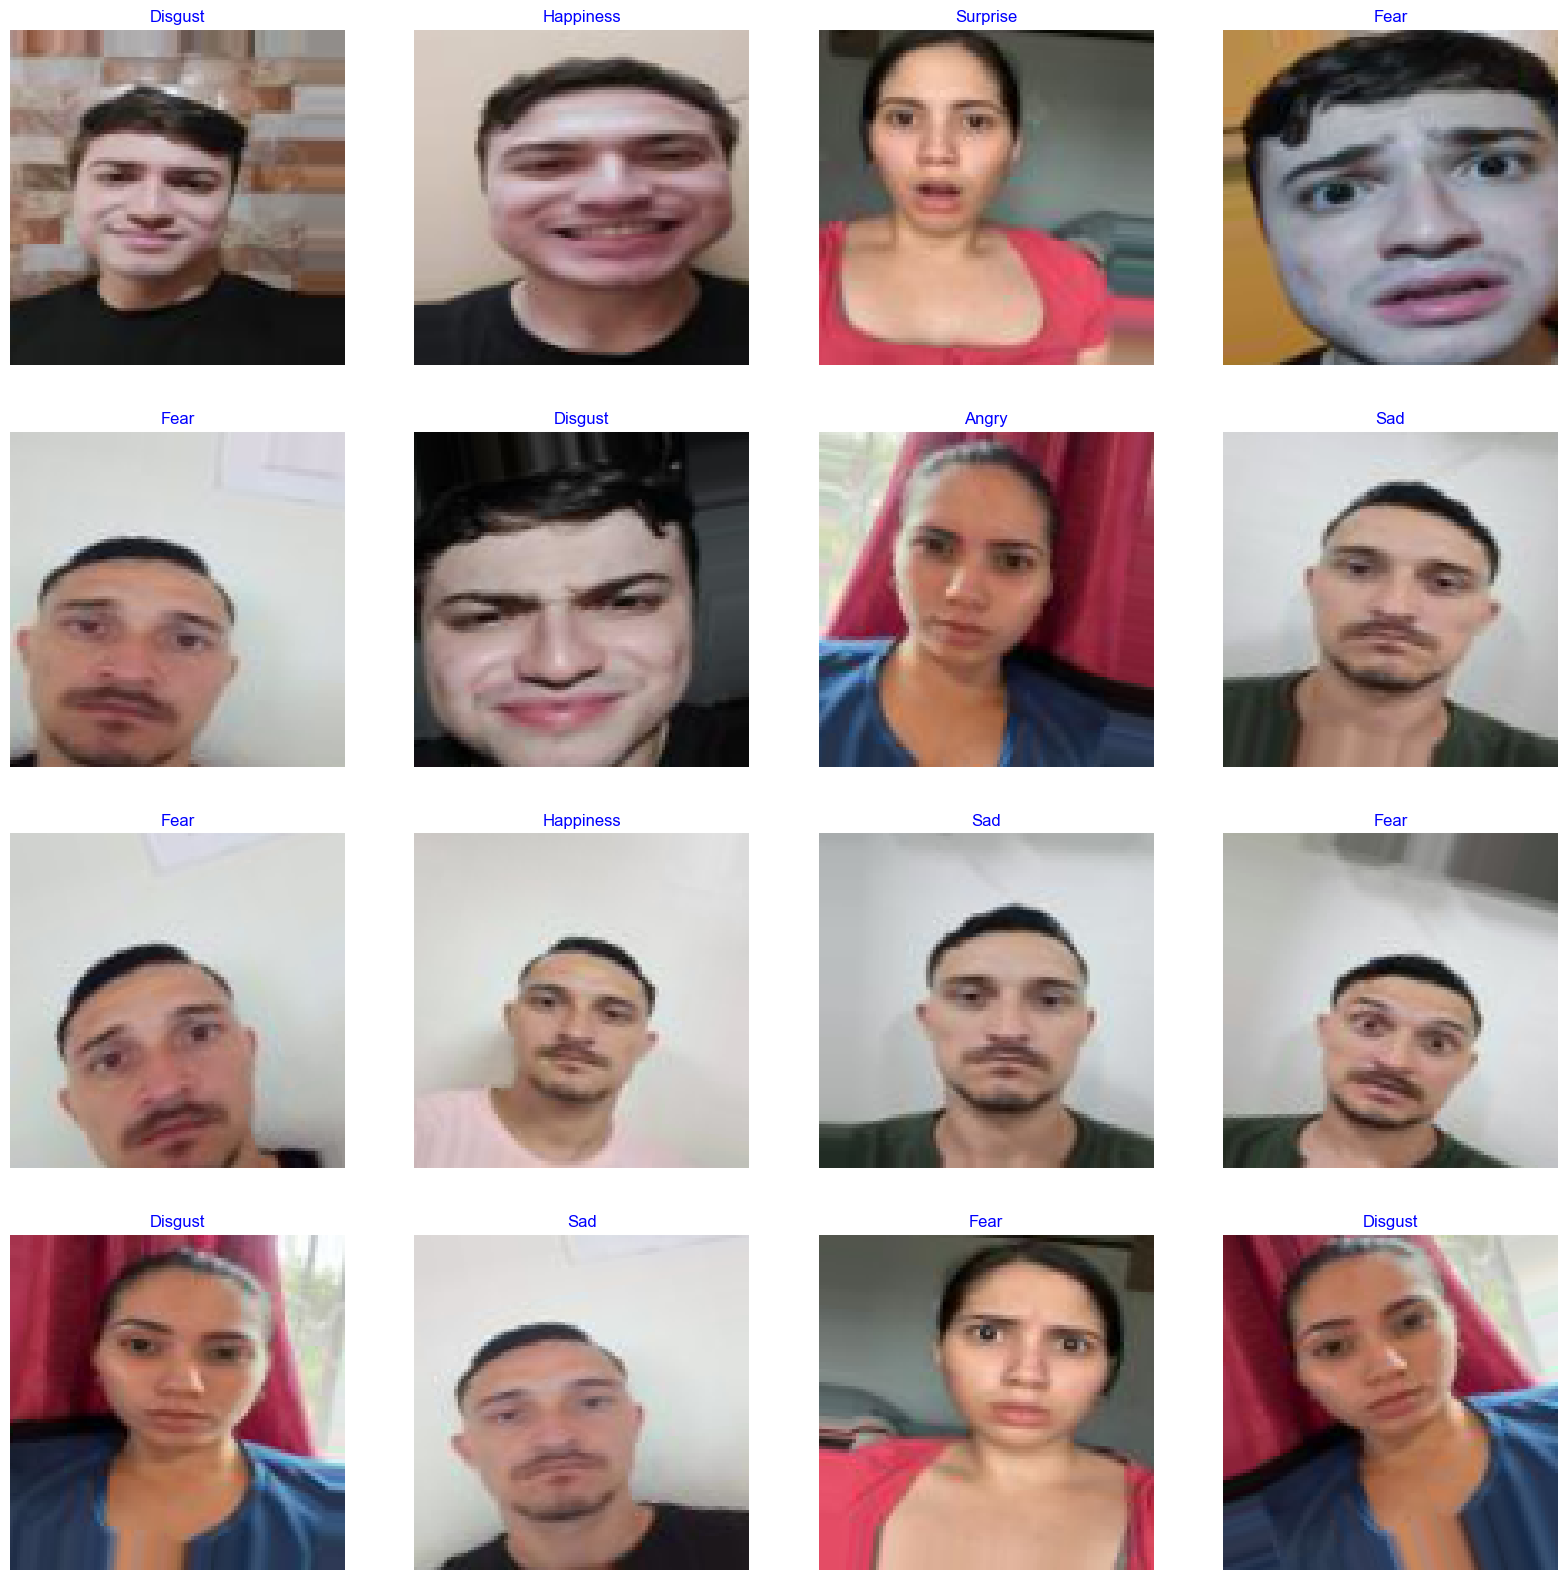

In [7]:
classes = ['Angry', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']     
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] /255     # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

MODEL STRUCTURE

In [8]:
from tensorflow.keras.optimizers import RMSprop, SGD
#Create Model Structure
img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Número de clases en el conjunto de datos

# Crear el modelo Sequential
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de aplanamiento
model.add(Flatten())

# Capa completamente conectada con regularización L2
model.add(Dense(256, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
model.add(Dropout(0.5))

# Capa de salida con activación softmax para clasificación multiclase
model.add(Dense(class_count, activation='softmax'))

# Compilar el modelo
model.compile(RMSprop(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                        

In [9]:
batch_size = 16   # set batch size for training
epochs =  265 # number of all epochs in training

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/265
11/11 [==============================] - 6s 110ms/step - loss: 47.1137 - accuracy: 0.0966 - val_loss: 45.8129 - val_accuracy: 0.1948 - lr: 1.0000e-04
Epoch 2/265
11/11 [==============================] - 1s 65ms/step - loss: 44.8198 - accuracy: 0.2273 - val_loss: 44.3297 - val_accuracy: 0.1299 - lr: 1.0000e-04
Epoch 3/265
11/11 [==============================] - 1s 63ms/step - loss: 43.8910 - accuracy: 0.1989 - val_loss: 43.1183 - val_accuracy: 0.1169 - lr: 1.0000e-04
Epoch 4/265
11/11 [==============================] - 1s 64ms/step - loss: 42.7418 - accuracy: 0.2386 - val_loss: 42.4429 - val_accuracy: 0.1818 - lr: 1.0000e-04
Epoch 5/265
11/11 [==============================] - 1s 64ms/step - loss: 41.8348 - accuracy: 0.2216 - val_loss: 41.1473 - val_accuracy: 0.1299 - lr: 1.0000e-04
Epoch 6/265
11/11 [==============================] - 1s 63ms/step - loss: 40.5355 - accuracy: 0.2557 - val_loss: 39.8859 - val_accuracy: 0.1948 - lr: 1.0000e-04
Epoch 7/265
11/11 [==============

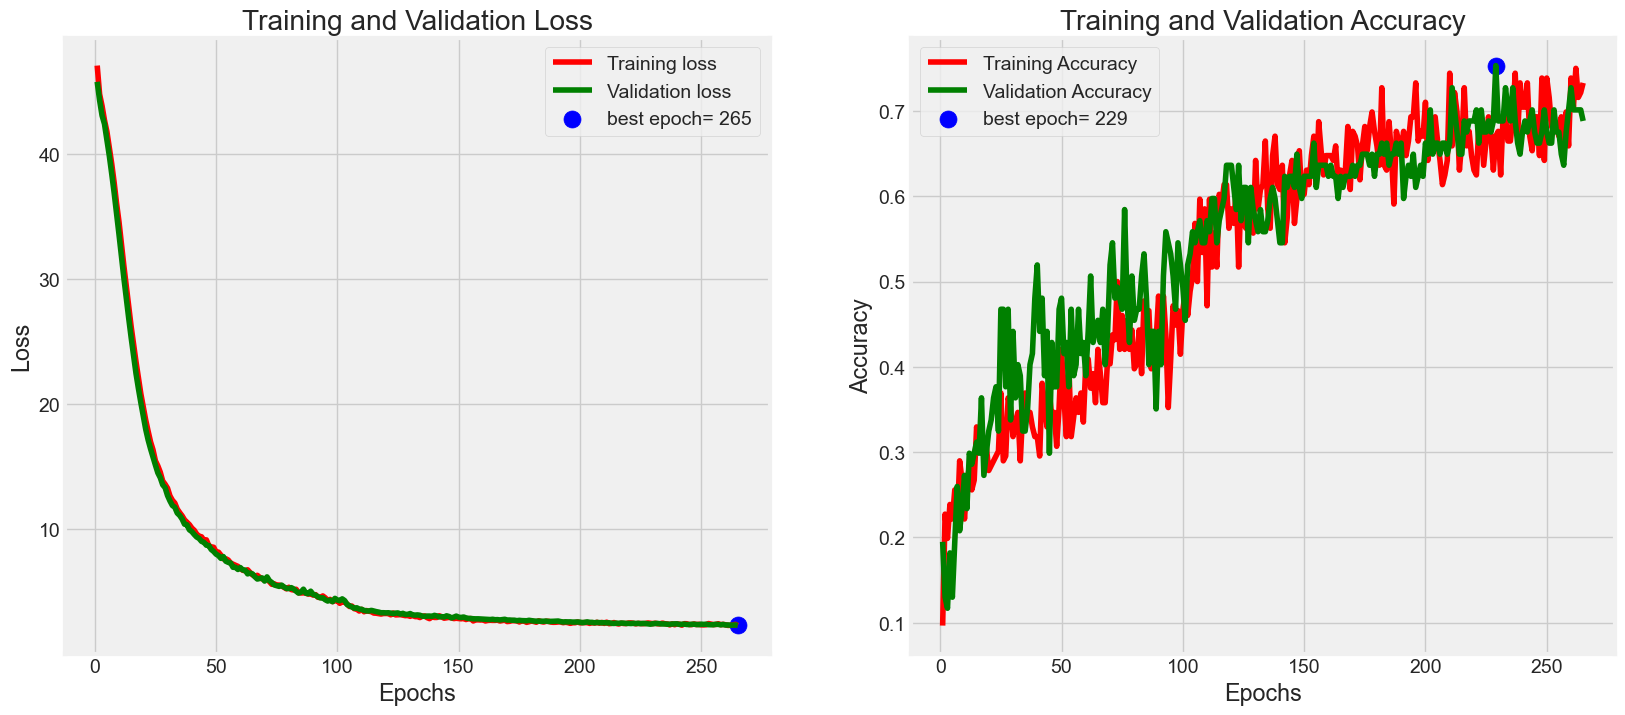

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

EVALUACIÓN DEL MODELO

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 97ms/step - loss: 2.4324 - accuracy: 0.6875
Train Loss:  2.142155647277832
Train Accuracy:  0.8125
--------------------
Validation Loss:  2.1333744525909424
Validation Accuracy:  0.6875
--------------------
Test Loss:  2.4323630332946777
Test Accuracy:  0.6875


Predictions

In [12]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

5/5 [==============================] - 1s 113ms/step


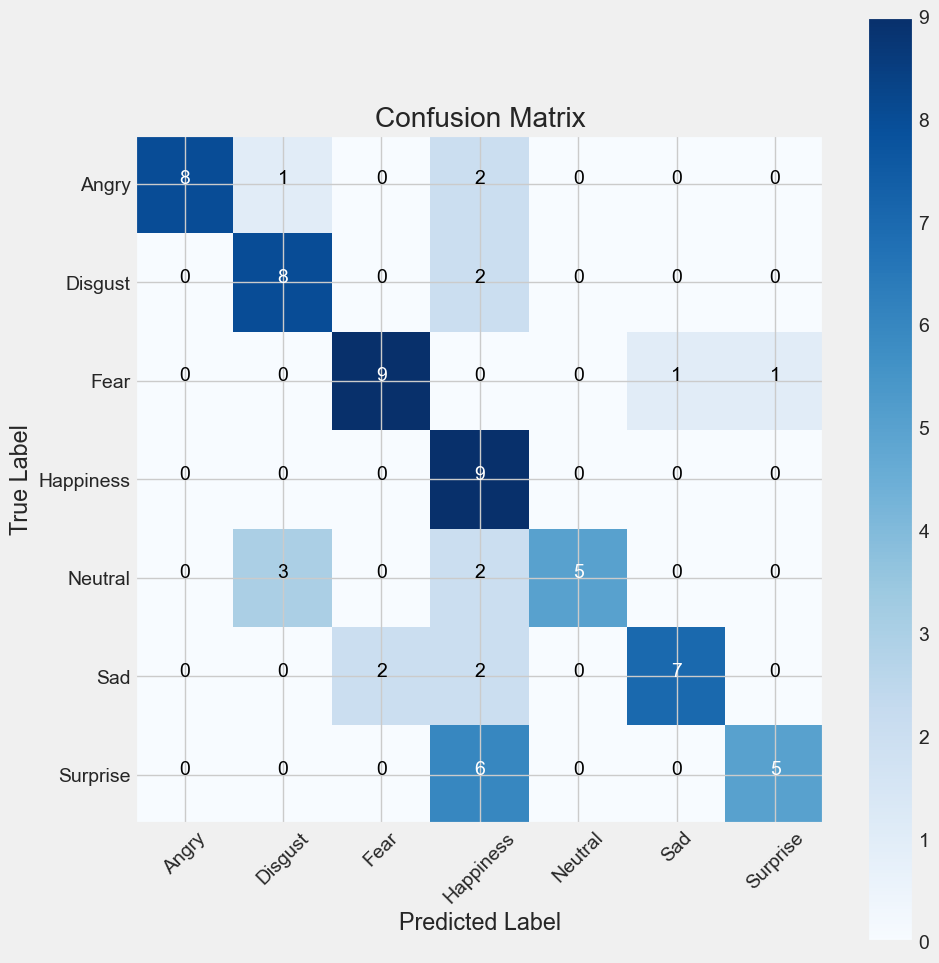

In [13]:

classes = ['Angry', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       1.00      0.73      0.84        11
     Disgust       0.67      0.80      0.73        10
        Fear       0.82      0.82      0.82        11
   Happiness       0.39      1.00      0.56         9
     Neutral       1.00      0.50      0.67        10
         Sad       0.88      0.64      0.74        11
    Surprise       0.83      0.45      0.59        11

    accuracy                           0.70        73
   macro avg       0.80      0.71      0.71        73
weighted avg       0.81      0.70      0.71        73



Gurdar el modelo y cargarlo para predecir(cambiarlo porque no ha sido ejecutado)

In [20]:
model.save('emotions.h5')

In [21]:
loaded_model = tf.keras.models.load_model('./emotions.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [22]:
image_path = './emociones_procesadas/test/Disgust/LuzDisgust2.jpeg'
image = Image.open(image_path)
# Preprocesar la imagen
img = image.resize((100, 100))  # Redimensionar la imagen a 80x80 (según el tamaño utilizado en el modelo)
img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convertir la imagen a un array
img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para la muestra (batch)

# Normalizar los valores de píxel al rango [0, 1]
img_array = img_array / 255.0

# Realizar la predicción
predictions = loaded_model.predict(img_array)

# Obtener el índice de la clase con mayor probabilidad
predicted_index = np.argmax(predictions[0])

# Lista de etiquetas de clases
class_labels = ['Angry', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']

# Obtener la etiqueta de clase predicha
predicted_label = class_labels[predicted_index]

# Mostrar la etiqueta predicha
print(f"Predicción: {predicted_label}")

1/1 [==============================] - 0s 106ms/step
Predicción: Disgust
